In [1]:
import pyrootutils
import os

# Set the project root using the current working directory
project_root = pyrootutils.setup_root(os.getcwd(), indicator=".git", pythonpath=True, cwd=True)
print("Working directory set to:", os.getcwd())

Working directory set to: /home/ec2-user/embedding-adapter


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import os
import torch
import pandas as pd
import numpy as np

from embedding_adapter.products_module import TripletModule

/home/ec2-user/embedding-adapter/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Load the trained model from checkpoint
checkpoint_path = f"logs/csts/triplet_model_2025-05-12_21-04-07_88a17f/checkpoints/triplet-model-best-ood-val.ckpt"

model = TripletModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'), dtype=dtype)
model.eval()

TripletModule(
  (adapter): MixtureOfAdapters(
    (experts): ModuleList(
      (0-63): 64 x Sequential(
        (0): Linear(in_features=1024, out_features=64, bias=True)
        (1): Dropout(p=0.3, inplace=False)
        (2): Linear(in_features=64, out_features=512, bias=True)
      )
    )
    (gate_network): Sequential(
      (0): Linear(in_features=1024, out_features=64, bias=True)
    )
  )
  (loss_fn): TripletLoss(
    (criterion): CrossEntropyLoss()
  )
  (in_batch_loss_fn): JointInfoNCELoss()
)

In [22]:
def cosine_similarity_matrix(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
    norm_tensor1 = tensor1 / tensor1.norm(dim=1, keepdim=True)
    norm_tensor2 = tensor2 / tensor2.norm(dim=1, keepdim=True)
    return torch.mm(norm_tensor1, norm_tensor2.t())

In [23]:
embedding_model = "simcse"

train_tasks = pd.read_parquet(f"data/csts/{embedding_model}/train_tasks.parquet")
train_tasks['split'] = 'train'

ood_tasks = pd.read_parquet(f"data/csts/{embedding_model}/ood_tasks.parquet")
ood_tasks['split'] = 'ood'

In [24]:
tasks = pd.concat([train_tasks, ood_tasks])

In [25]:
task_embeddings = torch.tensor(np.stack(tasks['embedding_task'])).to(dtype)

In [26]:
# task_embeddings = task_adapter.encode(task_embeddings.to(dtype=torch.float32)).detach().cpu()

In [27]:
task_embeddings = torch.nn.functional.normalize(task_embeddings, dim=1, p=2)

In [28]:
task_embeddings

tensor([[-0.0147, -0.0324,  0.0108,  ..., -0.0266, -0.0074, -0.0269],
        [-0.0514,  0.0084,  0.0266,  ..., -0.0157,  0.0094,  0.0276],
        [ 0.0007, -0.0578,  0.0006,  ..., -0.0432, -0.0252, -0.0125],
        ...,
        [-0.0056, -0.0447,  0.0106,  ...,  0.0145,  0.0470, -0.0631],
        [ 0.0400, -0.0597,  0.0538,  ...,  0.0504,  0.0135,  0.0043],
        [-0.0649,  0.0038, -0.0107,  ..., -0.0382, -0.0139, -0.0158]])

In [29]:
noisy_cosine_sim = cosine_similarity_matrix(task_embeddings, task_embeddings + 0.03 * torch.randn_like(task_embeddings))
noisy_cosine_sim

tensor([[0.7179, 0.1032, 0.0894,  ..., 0.1867, 0.1488, 0.1633],
        [0.1190, 0.7160, 0.0716,  ..., 0.2077, 0.0678, 0.1653],
        [0.0723, 0.1273, 0.7154,  ..., 0.1066, 0.1294, 0.0854],
        ...,
        [0.1828, 0.1656, 0.0968,  ..., 0.7273, 0.1750, 0.1999],
        [0.1741, 0.0706, 0.1638,  ..., 0.1746, 0.7315, 0.1758],
        [0.1376, 0.1744, 0.0939,  ..., 0.2422, 0.1507, 0.7297]])

In [30]:
cosine_sim = cosine_similarity_matrix(task_embeddings, task_embeddings)
cosine_sim

tensor([[1.0000, 0.1621, 0.1430,  ..., 0.2439, 0.2220, 0.1711],
        [0.1621, 1.0000, 0.1136,  ..., 0.2502, 0.1089, 0.2147],
        [0.1430, 0.1136, 1.0000,  ..., 0.1642, 0.1809, 0.0701],
        ...,
        [0.2439, 0.2502, 0.1642,  ..., 1.0000, 0.2490, 0.2421],
        [0.2220, 0.1089, 0.1809,  ..., 0.2490, 1.0000, 0.2202],
        [0.1711, 0.2147, 0.0701,  ..., 0.2421, 0.2202, 1.0000]])

In [37]:
tasks['cosine_sim'] = cosine_sim[1]

In [38]:
STEP_SIZE = 5
tasks_sorted = tasks[['id_task', 'task', 'cosine_sim', 'split', 'embedding_task']].sort_values(by='cosine_sim', ascending=False).iloc[:30*STEP_SIZE:STEP_SIZE]

In [39]:
tasks_sorted

,id_task,task,cosine_sim,split,embedding_task
3053,1885054d-d612-4fa2-a879-e2352abea2d1,Position relative to animal.,1.000000,train,"[-0.05142, 0.00836, 0.02664, -0.04254, 0.01160..."
1099,5dca2654-8997-4a6d-b98c-3baf2d32c30f,The position of the animal.,0.875083,train,"[-0.0397, 0.03662, 0.0412, -0.02383, -0.02571,..."
2946,f33e22a7-724b-44c9-b9a5-fccf2895c355,The posture of the animal.,0.845718,train,"[-0.05075, 0.03494, 0.02399, -0.0256, -0.0257,..."
1083,b99be8a0-75b2-4558-8f57-06cbcdcbf54e,The location of the animal.,0.837382,train,"[-0.02829, 0.01878, 0.04865, -0.02545, -0.0151..."
2850,fb1989cf-dbfa-481e-9aec-5a56e6767544,The animal's demeanor.,0.814530,train,"[-0.0327, 0.01443, 0.03644, -0.03427, -0.01068..."
3,0a0ccaf0-8377-4040-9d11-4d88dd026391,The type of animal.,0.808111,train,"[-0.03314, 0.00742, 0.04233, -0.03128, 0.01451..."
2193,2c6f5c27-eb80-46f5-af74-cff4c7925dcd,The animal's species.,0.803191,train,"[-0.02974, 0.0214, 0.0456, -0.0247, 0.01804, -..."
2901,07f309a9-0076-4324-9ebd-613930f115f3,The presence of a dog.,0.795393,train,"[-0.01567, 0.03867, 0.05154, -0.04, -0.03586, ..."
627,6b202343-8399-4d88-a24d-fd6142c10b87,A canine presence.,0.794130,ood,"[-0.02628, 0.02472, 0.05096, -0.03278, -0.0156..."
965,76a57d38-196a-410e-9517-34278e6453fb,The activity of animal.,0.786295,train,"[-0.03128, 0.03778, 0.05032, -0.03708, -0.0239..."


In [40]:
with torch.inference_mode():
    top_embeddings = torch.tensor(np.stack(tasks_sorted['embedding_task'])).to(device=device, dtype=dtype)
    gates = model.adapter.forward_gate(top_embeddings)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

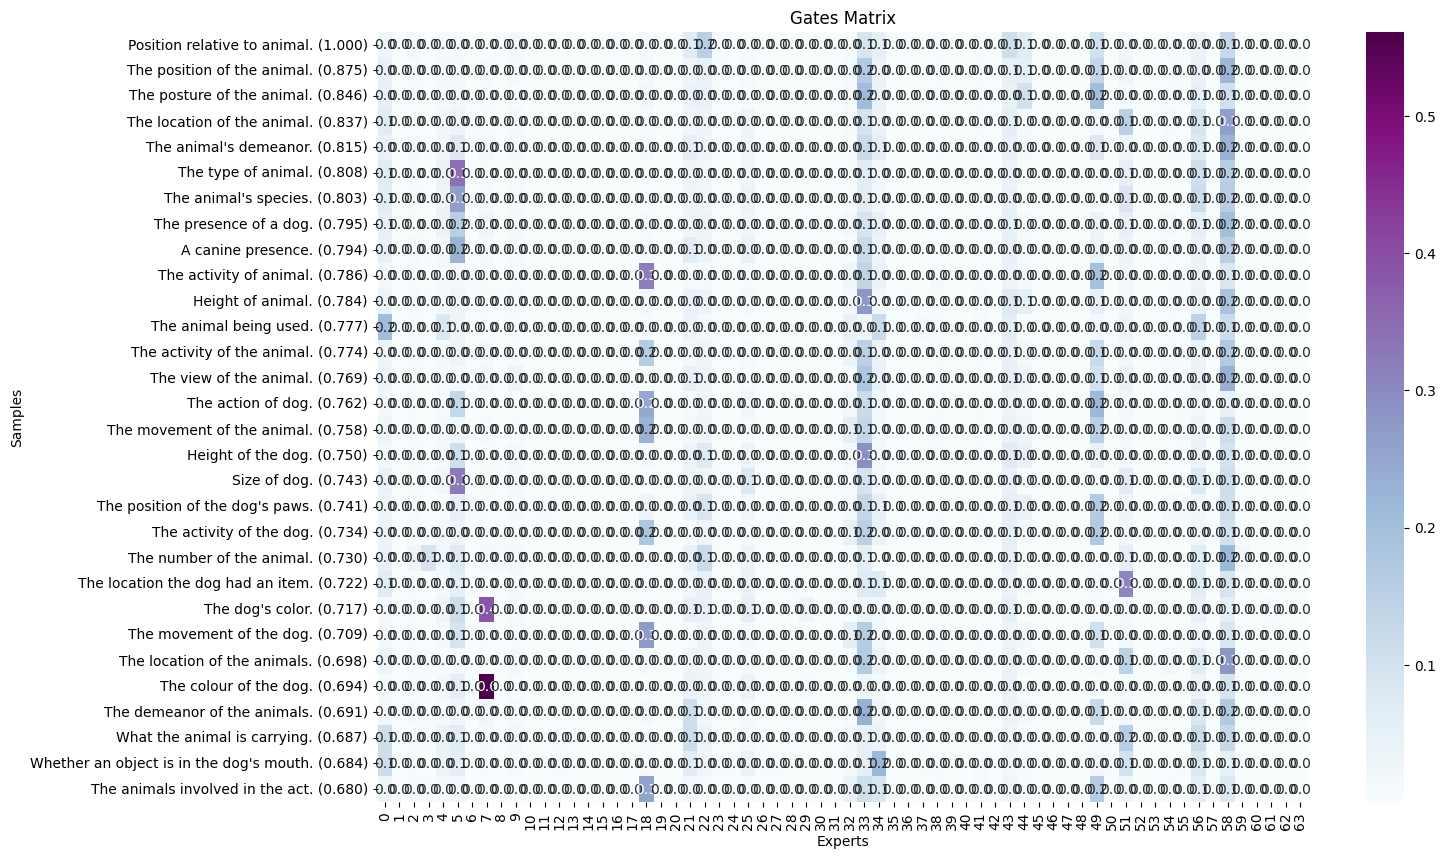

In [42]:
plt.figure(figsize=(15, 10))
labels = [f"{t} ({c:.3f})" for t, c in zip(tasks_sorted['task'].tolist(), tasks_sorted['cosine_sim'].tolist())]
sns.heatmap(gates.detach().cpu().numpy(), annot=True, fmt=".1f", cmap="BuPu", yticklabels=labels)
plt.title('Gates Matrix')
plt.xlabel('Experts')
plt.ylabel('Samples')
plt.show()

In [32]:
all_task_embeddings = task_embeddings.clone().to('cuda')
with torch.inference_mode():
    # all_task_embeddings = all_task_embeddings + 0.01 * torch.randn_like(all_task_embeddings).to('cuda')
    all_gates = model.adapter.forward_gate(all_task_embeddings)
top_gate_index = torch.argmax(all_gates, dim=1).cpu().numpy()

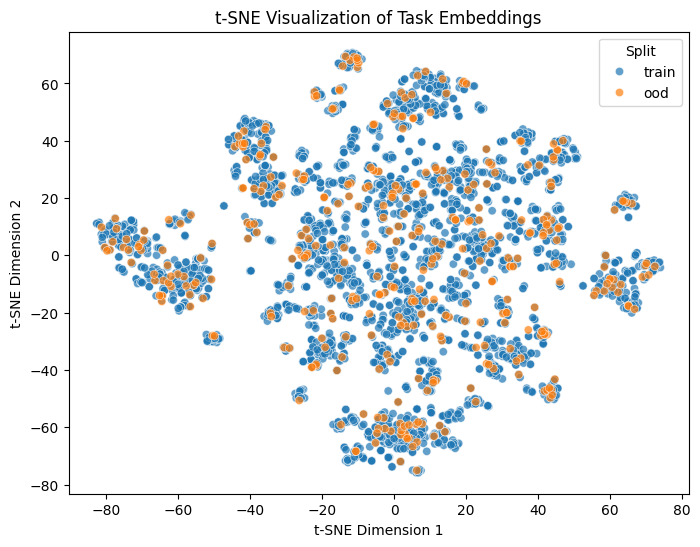

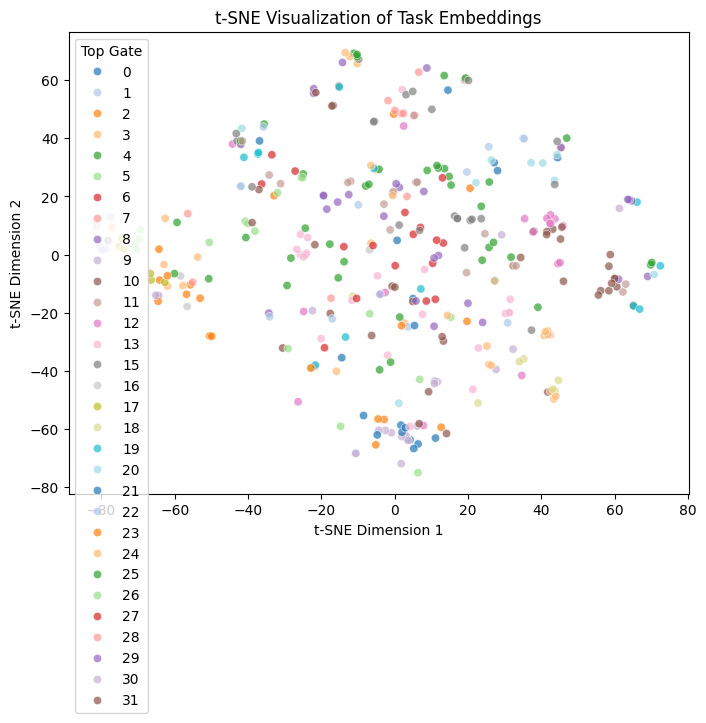

In [184]:
from sklearn.manifold import TSNE

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(task_embeddings.cpu().numpy())

# Create a DataFrame for visualization
tasks['tsne_x'] = embeddings_2d[:, 0]
tasks['tsne_y'] = embeddings_2d[:, 1]
tasks['top_gate_index'] = top_gate_index

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tasks, x='tsne_x', y='tsne_y', hue='split', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Task Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Split')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tasks[tasks['split'] == 'ood'], x='tsne_x', y='tsne_y', hue='top_gate_index', palette='tab20', alpha=0.7)
plt.title('t-SNE Visualization of Task Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Top Gate')
plt.show()

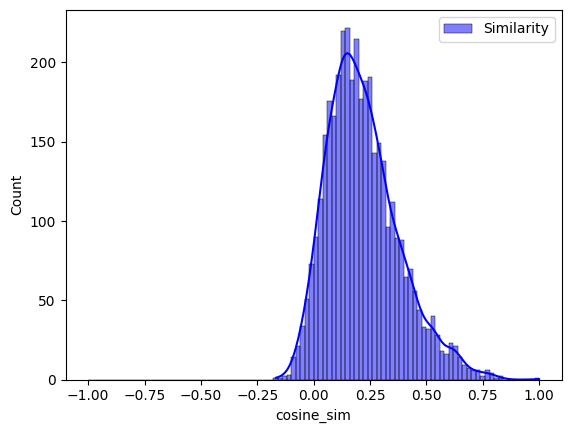

In [36]:
sns.histplot(tasks['cosine_sim'], binwidth=0.02, binrange=(-1, 1), color='blue', kde=True, label='Similarity')
plt.legend()
plt.show()